In [ ]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,
        shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [ ]:
# Add noise augmentation
def add_gaussian_noise(image):
    image = image / 255
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.2, dtype=tf.float32)
    noisy_image = image + noise
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)
    return noisy_image * 255

noisy_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        preprocessing_function=add_gaussian_noise
        )

noisy_generator = noisy_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,
        shuffle=True)



Found 31368 images belonging to 43 classes.


In [ ]:
# Image Tilting

tilted_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        rotation_range=45,
        fill_mode='nearest'
        )
tilted_generator = tilted_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,
        shuffle=True)

Found 31368 images belonging to 43 classes.


In [ ]:
# Combine generators
def combine_generators(gen1, gen2):
  for batch1, batch2 in zip(gen1, gen2):
    yield batch1
    yield batch2

combined_generator = combine_generators(train_generator, tilted_generator)

In [ ]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

In [ ]:
len(target_names)

43

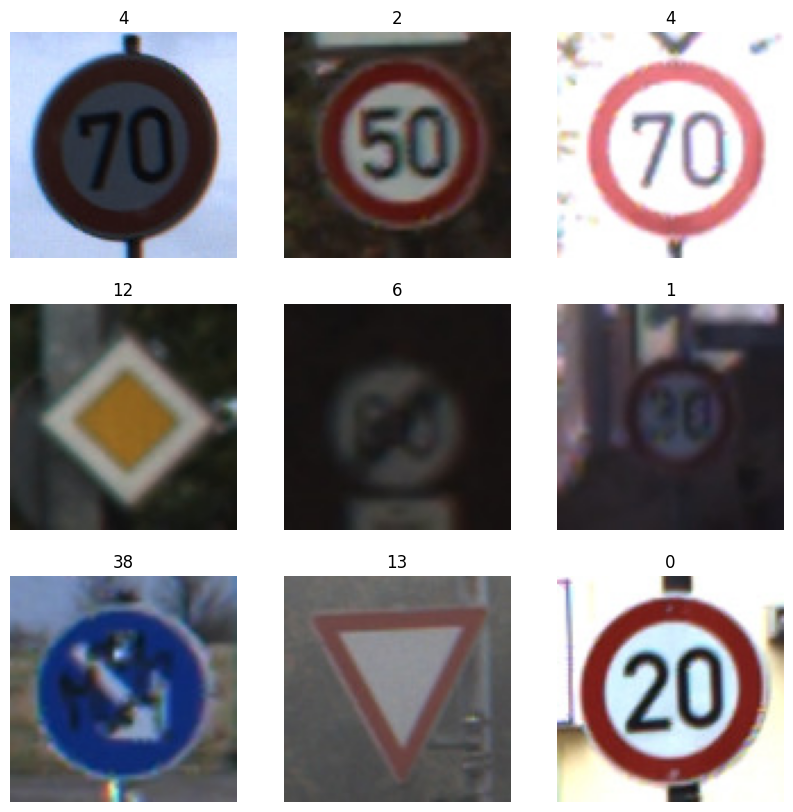

In [ ]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Assuming train_generator is a generator
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

In [ ]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(len(target_names), activation='softmax'))

from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model (excluding the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the layers in the base model
# for layer in base_model.layers:
#     layer.trainable = False

# Create a new model on top of the VGG16 base model
model = keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Conv2D(256, (1, 1), activation='relu'))
model.add(keras.layers.MaxPooling2D((1, 1)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(keras.layers.Dense(len(target_names), activation='softmax'))

model.compile(optimizer = Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# history = model.fit(
#         # train_generator,
#         combined_generator, # combined noisy and clear images
#         # steps_per_epoch=train_generator.samples // 32,
#         epochs=8,
#         validation_data=validation_generator,
#         # validation_steps=validation_generator.samples // 32
# )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Fit the model
history = model.fit(
    combined_generator,
    epochs=8,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    steps_per_epoch=2000
)

Epoch 1/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4194 - loss: 2.1309

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 299s 141ms/step - accuracy: 0.4195 - loss: 2.1304 - val_accuracy: 0.9276 - val_loss: 0.2876
Epoch 2/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 274s 137ms/step - accuracy: 0.9525 - loss: 0.1622 - val_accuracy: 0.9361 - val_loss: 0.2994
Epoch 3/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 264s 132ms/step - accuracy: 0.9688 - loss: 0.1120 - val_accuracy: 0.9560 - val_loss: 0.2661
Epoch 4/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 263s 131ms/step - accuracy: 0.9808 - loss: 0.0728 - val_accuracy: 0.9690 - val_loss: 0.1473
Epoch 5/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 265s 132ms/step - accuracy: 0.9817 - loss: 0.0706 - val_accuracy: 0.9680 - val_loss: 0.1431
Epoch 6/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 261s 130ms/step - accuracy: 0.9854 - loss: 0.0553 - val_accuracy: 0.9688 - val_loss: 0.1463
Epoch 7/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 263s 131ms/step - accuracy: 0.9867 - loss: 0.0561 - val_accuracy: 0.9691 - val_loss: 0.1550
Epoch 8/8
1012/2000 ━━━━━━━━━━━━━━━━━━━━ 2:04 126ms/step - accuracy: 0.9897 - l

246/246 - 8s - 32ms/step - accuracy: 0.9787 - loss: 0.1030
0.10304179787635803 0.9787017107009888


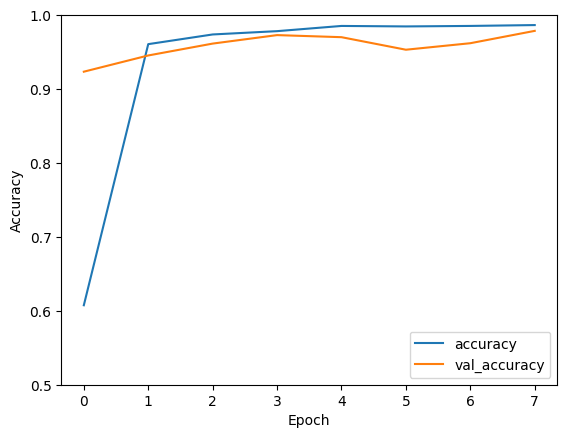

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print(test_loss,test_acc)

In [ ]:
predictions = model.predict(validation_generator)

246/246 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step


In [ ]:


from sklearn.metrics import confusion_matrix
predictions_new = np.argmax(predictions,axis=1)
confusion_matrix(validation_generator.classes, predictions_new)

array([[ 0,  3,  3, ...,  0,  0,  2],
       [ 4, 25, 30, ...,  7,  2,  4],
       [ 5, 33, 28, ...,  7,  3,  3],
       ...,
       [ 2,  5,  5, ...,  0,  1,  1],
       [ 0,  3,  2, ...,  0,  1,  0],
       [ 0,  2,  2, ...,  0,  0,  0]])

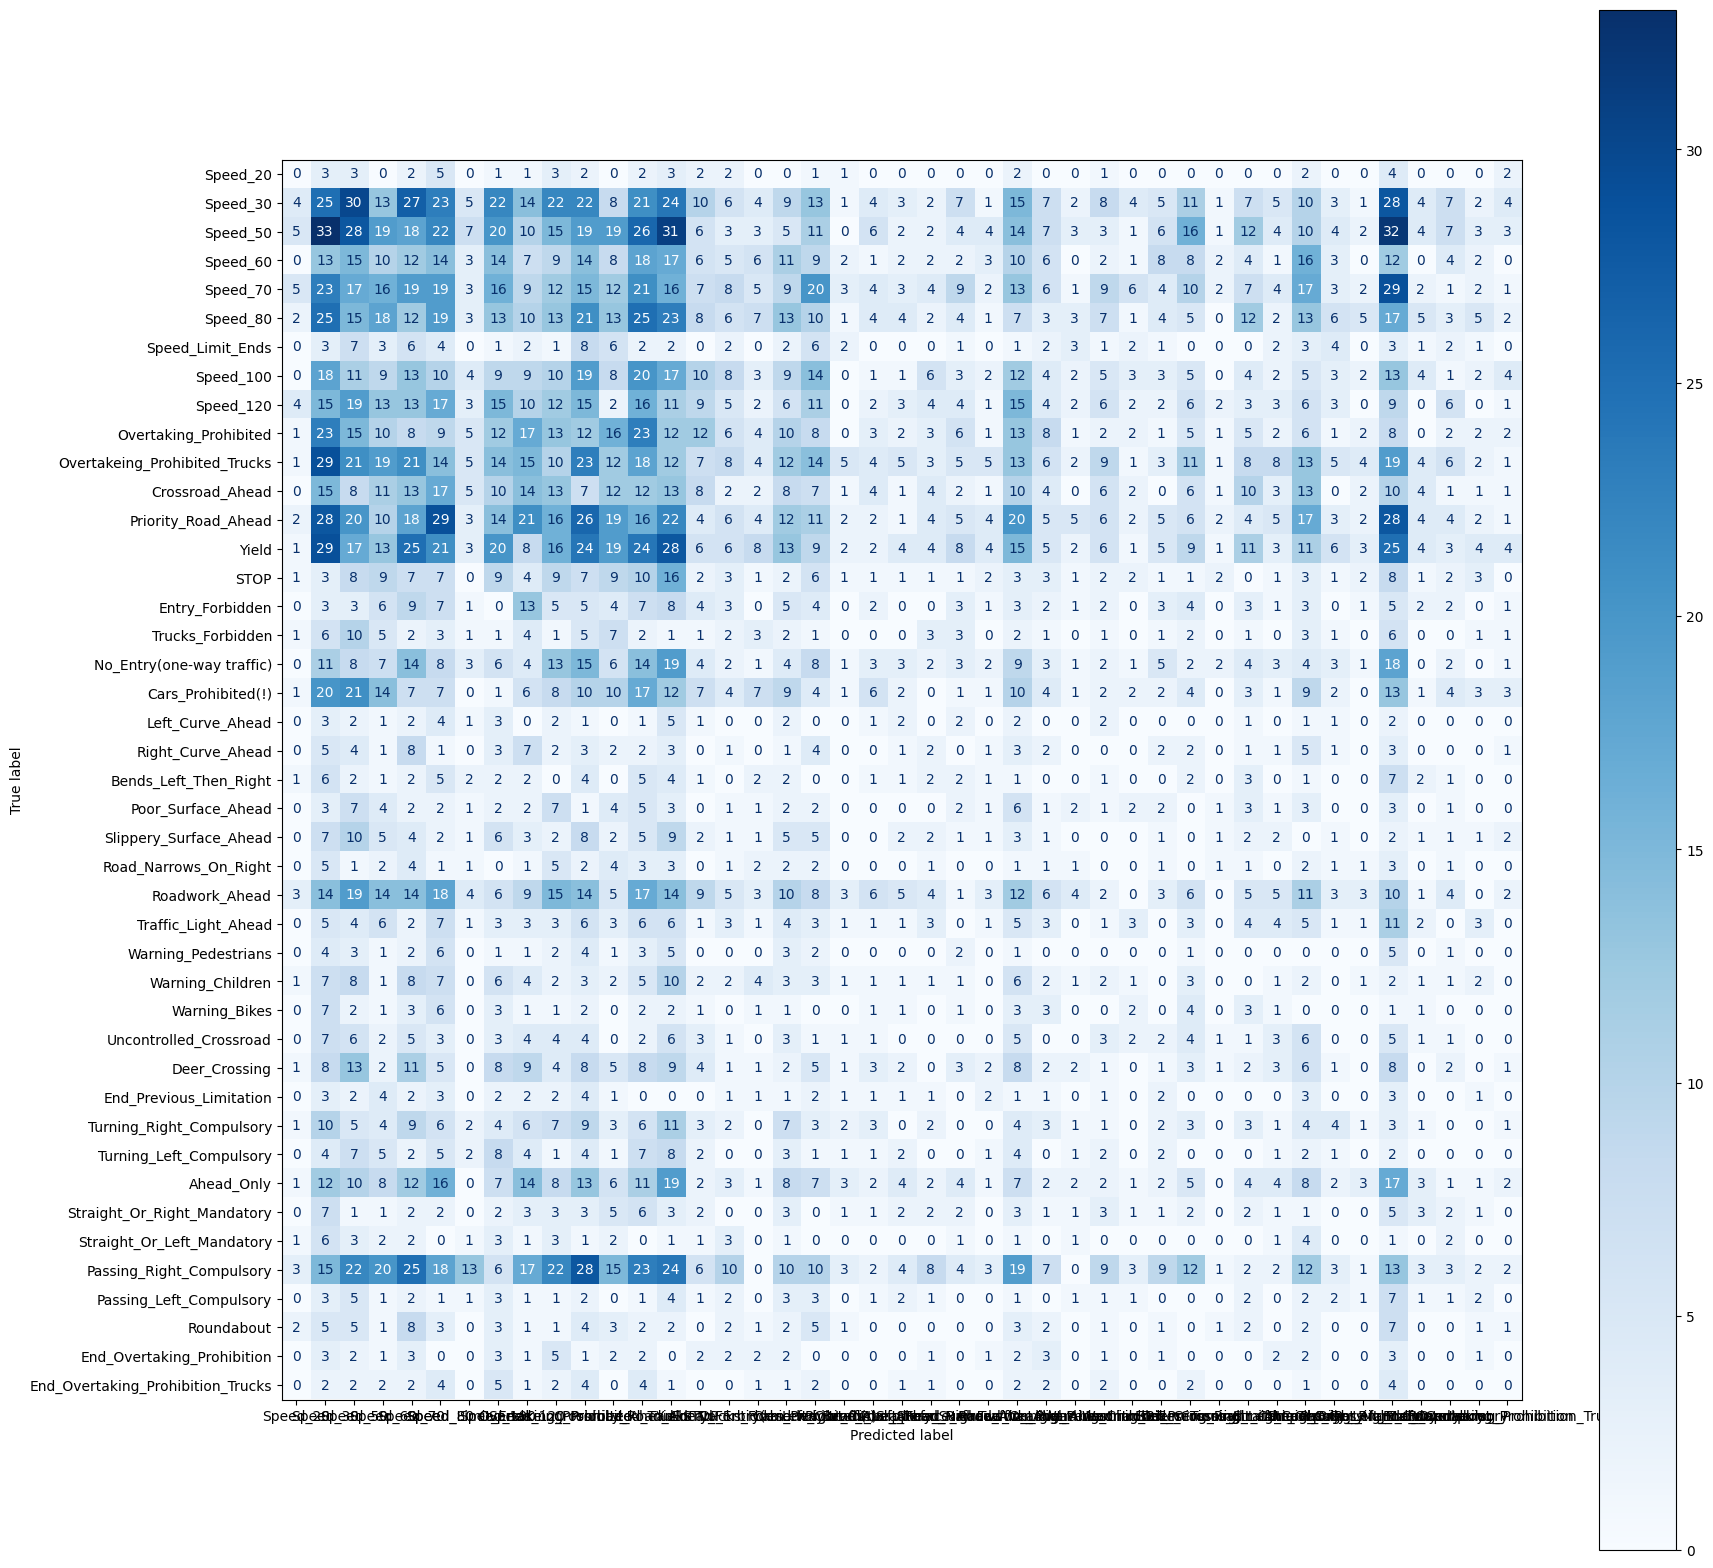

In [ ]:
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(validation_generator.classes, predictions_new)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(20,20)) # For changing the size of the plot
disp.plot(ax=ax, cmap="Blues", values_format='.5g')
